In [1]:
# installs
!pip install pydub
!pip install resampy
!pip install librosa --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.6 MB/s eta 0:00:00


In [2]:
# imports
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [3]:
mypath = "/content/drive/MyDrive/ML_project/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))]

In [4]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)

In [5]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [6]:
p_diag = pd.read_csv("/content/drive/MyDrive/ML_project/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None) # patient diagnosis file

In [7]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files


## **Data augumentation**

In [8]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    return data
def stretch_process(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)
def pitch_process(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

## **Data process functions**

In [9]:
def extract_process(data, sample_rate): # for svm,knn,naive byes,and decsion tree model
    output_result = np.array([])

    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    output_result = np.hstack((output_result, mean_zero))

    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out))

    return output_result

In [10]:
def extract_process_with_mel_spectogram(data, sample_rate): # for 1d Cnn model
    output_result = np.array([])

    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    output_result = np.hstack((output_result, mean_zero))

    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, mel_spectogram))

    return output_result

## **Feature extraction**

In [11]:
def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it,
    and extracts several audio features including mean values of MFCC, Zero Crossing Rate,
    Chromagram, Root Mean Square Energy, and Mel Spectrogram from the original and its augmented versions.
    """
    try:
        # Load the original audio file
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=42, offset=0.6)

        # Extract features from the original audio data
        extracted_features = extract_process(audio, sample_rate)
        result = np.array(extracted_features)

        # Add noise and extract features
        noise_out = add_noise(audio)
        output_2 = extract_process(noise_out, sample_rate)
        result = np.vstack((result, output_2))

        # Time-stretch and then pitch-shift before extracting features
        new_out = stretch_process(audio,0.8)
        stretch_pitch = pitch_process(new_out, sample_rate,pitch_factor=0.7)
        output_3 = extract_process(stretch_pitch, sample_rate)
        result = np.vstack((result, output_3))

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print("Error Details:", e)
        return None

    return result

In [17]:
def extract_features_with_mel(file_name):
    try:
        # Load the original audio file
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=42, offset=0.6)

        # Extract features from the original audio data
        extracted_features = extract_process_with_mel_spectogram(audio, sample_rate)
        result = np.array(extracted_features)

        # Add noise and extract features
        noise_out = add_noise(audio)
        output_2 = extract_process_with_mel_spectogram(noise_out, sample_rate)
        result = np.vstack((result, output_2))

        # Time-stretch and then pitch-shift before extracting features
        new_out = stretch_process(audio,0.8)
        stretch_pitch = pitch_process(new_out, sample_rate,pitch_factor=0.7)
        output_3 = extract_process_with_mel_spectogram(stretch_pitch, sample_rate)
        result = np.vstack((result, output_3))

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print("Error Details:", e)
        return None

    return result

In [12]:
features = []

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Finished feature extraction from  920  files


In [13]:
features.shape

(920, 3, 54)

In [18]:
features_with_mel = []

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features_with_mel(file_name)
    features_with_mel.append(data)

print('Finished feature extraction from ', len(features_with_mel), ' files')
features_with_mel = np.array(features_with_mel)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Finished feature extraction from  920  files


In [19]:
features_with_mel.shape

(920, 3, 182)

In [20]:
# delete the very rare diseases
new_features = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

new_labels = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [21]:
new_features_with_mel = np.delete(features_with_mel, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

new_labels_with_mel = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [22]:
# print class counts
unique_elements, counts_elements = np.unique(new_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


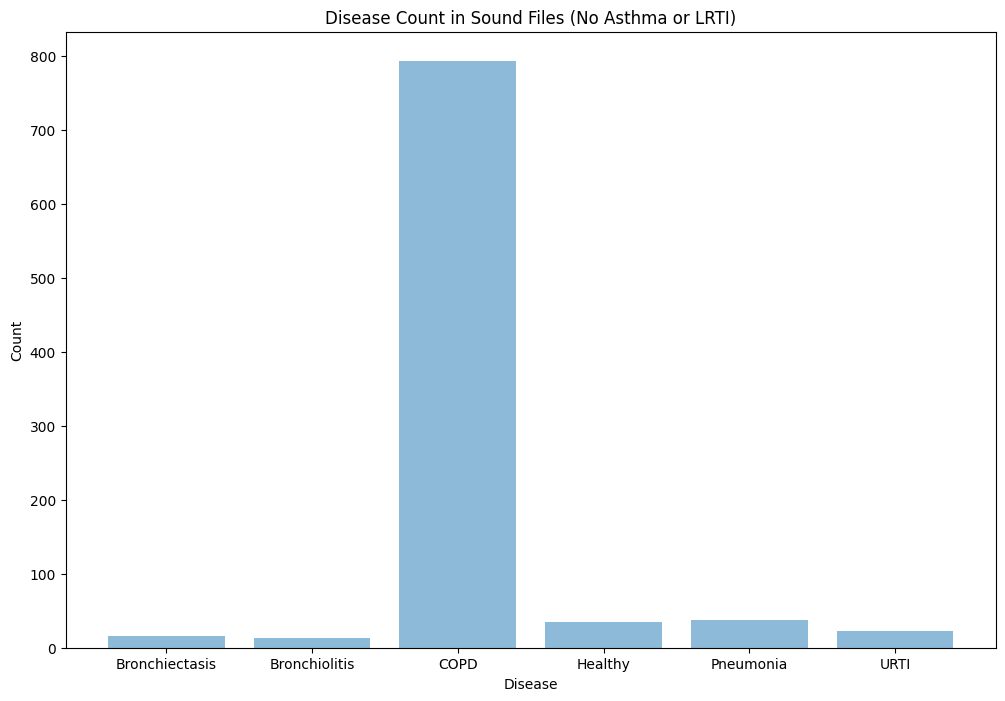

In [23]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

In [25]:
flattened_features = new_features.reshape(-1, 54)
augmented_labels = np.repeat(labels, 3)

In [26]:
flattened_features_with_mel = new_features_with_mel.reshape(-1, 182)
augmented_labels_with_mel = np.repeat(labels, 3)

In [27]:
augmented_features = np.reshape(features, (-1, 54))  # Flatten the feature sets

mask = ~np.isin(augmented_labels, ['Asthma', 'LRTI'])
augmented_features = augmented_features[mask]
augmented_labels = augmented_labels[mask]

In [28]:
augmented_features_with_mel = np.reshape(features_with_mel, (-1, 182))  # Flatten the feature sets

mask = ~np.isin(augmented_labels_with_mel, ['Asthma', 'LRTI'])
augmented_features_with_mel = augmented_features_with_mel[mask]
augmented_labels_with_mel = augmented_labels_with_mel[mask]

In [29]:
le = LabelEncoder()
i_labels = le.fit_transform(augmented_labels)
oh_labels = to_categorical(i_labels)

In [30]:
i_labels_with_mel = le.fit_transform(augmented_labels_with_mel)
oh_labels_with_mel = to_categorical(i_labels_with_mel)

In [31]:
oh_labels.shape

(2751, 6)

In [32]:
flattened_features.shape

(2751, 54)

In [35]:
oh_labels_with_mel.shape

(2751, 6)

In [36]:
flattened_features_with_mel.shape

(2751, 182)

In [60]:
x_train, x_test, y_train, y_test = train_test_split(flattened_features, oh_labels, stratify=oh_labels,
                                                    test_size=0.2, random_state = 42)


## **Models**

### **Suport Vector Machine model**

In [105]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_1d = le.fit_transform(np.argmax(y_train, axis=1)) # Converting one-hot encoded labels to 1D

svm=SVC(kernel='linear')
svm.fit(x_train,y_train_1d) # Using the 1D labels for training

SVC(kernel='linear')

In [71]:
y_test_1d = le.fit_transform(np.argmax(y_test, axis=1)) # Converting one-hot encoded labels to 1D
y_pred_svm = svm.predict(x_test)

In [84]:
accuracy_svm=accuracy_score(y_test_1d, y_pred_svm)
print(accuracy_svm)

0.8765880217785844


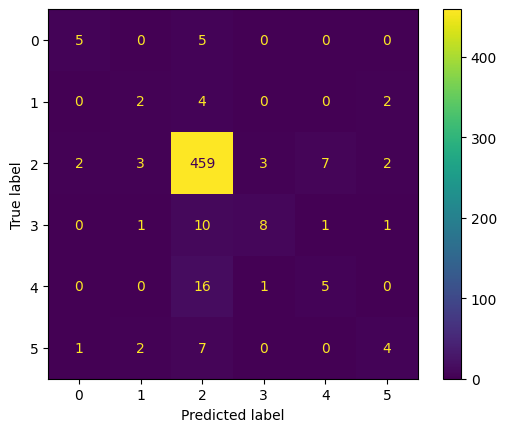

In [73]:
# confusion matrix
confusion_mtx = confusion_matrix(y_test_1d, y_pred_svm)

# Displaying the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()

In [89]:
# Classification report
print(classification_report(y_test_1d, y_pred_svm))

              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.25      0.25      0.25         8
           2       0.92      0.96      0.94       476
           3       0.67      0.38      0.48        21
           4       0.38      0.23      0.29        22
           5       0.44      0.29      0.35        14

    accuracy                           0.88       551
   macro avg       0.55      0.43      0.48       551
weighted avg       0.86      0.88      0.86       551



### **Naive Bayes Classifier**

In [68]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier on the training data
nb_classifier.fit(x_train, y_train_1d)

GaussianNB()

In [70]:
y_pred_nb=nb_classifier.predict(x_test)

In [82]:
accuracy_nb=accuracy_score(y_test_1d, y_pred_nb)
print(accuracy_nb)

0.7495462794918331


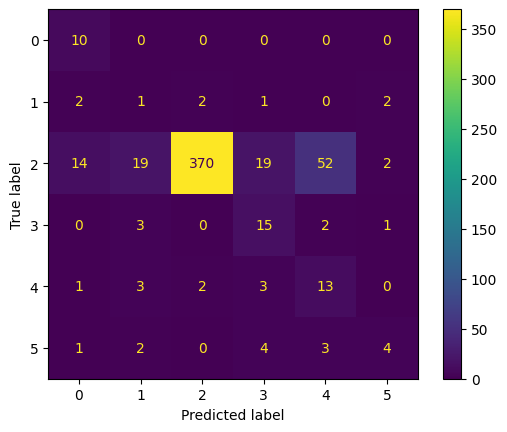

In [75]:
# confusion  matrix
confusion_mtx = confusion_matrix(y_test_1d, y_pred_nb)

# Displaying the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()


In [90]:
#Classification Report
print(classification_report(y_test_1d, y_pred_nb))

              precision    recall  f1-score   support

           0       0.36      1.00      0.53        10
           1       0.04      0.12      0.06         8
           2       0.99      0.78      0.87       476
           3       0.36      0.71      0.48        21
           4       0.19      0.59      0.28        22
           5       0.44      0.29      0.35        14

    accuracy                           0.75       551
   macro avg       0.39      0.58      0.43       551
weighted avg       0.89      0.75      0.80       551



### **K-Nearest Neighbours Model**

In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a KNN classifier with k=5
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier on the training data
knn_classifier.fit(x_train, y_train_1d)


KNeighborsClassifier()

In [77]:
y_pred_knn=knn_classifier.predict(x_test)

In [80]:
accuracy_knn= accuracy_score(y_test_1d, y_pred_knn)
print(accuracy_knn)

0.867513611615245


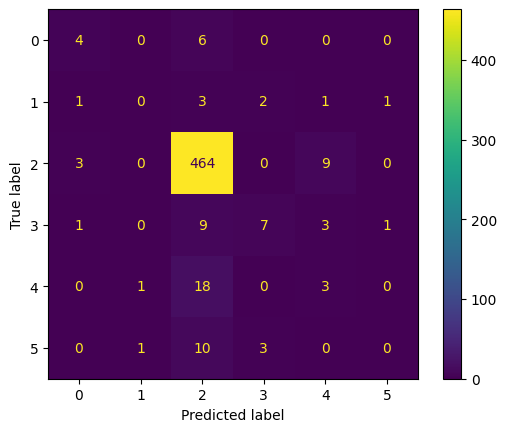

In [85]:
# confusion matrix
confusion_mtx = confusion_matrix(y_test_1d, y_pred_knn)

# Displaying the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()

In [92]:
# Classification report
print(classification_report(y_test_1d, y_pred_knn))

              precision    recall  f1-score   support

           0       0.44      0.40      0.42        10
           1       0.00      0.00      0.00         8
           2       0.91      0.97      0.94       476
           3       0.58      0.33      0.42        21
           4       0.19      0.14      0.16        22
           5       0.00      0.00      0.00        14

    accuracy                           0.87       551
   macro avg       0.35      0.31      0.32       551
weighted avg       0.82      0.87      0.84       551



### **Decision tree Model**

In [100]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

d_tree=DecisionTreeClassifier()
d_tree.fit(x_train,y_train_1d)


DecisionTreeClassifier()

In [101]:
y_pred_dtree=d_tree.predict(x_test)

In [102]:
accuracy_dtree=accuracy_score(y_test_1d, y_pred_dtree)
print(accuracy_dtree)

0.8584392014519057


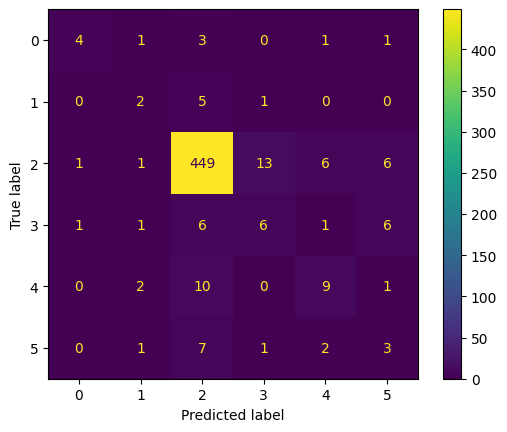

In [103]:
# confusion Matrix
confusion_mtx = confusion_matrix(y_test_1d, y_pred_dtree)

# Displaying the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()

In [104]:
# Classification report
print(classification_report(y_test_1d, y_pred_dtree))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.25      0.25      0.25         8
           2       0.94      0.94      0.94       476
           3       0.29      0.29      0.29        21
           4       0.47      0.41      0.44        22
           5       0.18      0.21      0.19        14

    accuracy                           0.86       551
   macro avg       0.46      0.42      0.43       551
weighted avg       0.86      0.86      0.86       551



### **1D Cnn model**

In [40]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(flattened_features_with_mel, oh_labels_with_mel, stratify=oh_labels_with_mel,
                                                    test_size=0.2, random_state = 42)

In [41]:
#SCALER & TRANSFORMATION
scaler_data = StandardScaler()

In [42]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2200, 182)
(2200, 6)
(551, 182)
(551, 6)


In [43]:
x_train = scaler_data.fit_transform(x_train)
x_test = scaler_data.transform(x_test)

In [44]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)

In [52]:
from tensorflow.keras import layers, Sequential

num_labels = len(np.unique(new_labels))  # Determine the number of unique classes

Model = Sequential([
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=num_labels, activation='softmax')
])

In [53]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

In [54]:
Conv1D_Model = Model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.7101 - loss: 1.0679 - val_accuracy: 0.8639 - val_loss: 0.6293
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 487ms/step - accuracy: 0.8634 - loss: 0.6610 - val_accuracy: 0.8639 - val_loss: 0.6638
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 529ms/step - accuracy: 0.8568 - loss: 0.6511 - val_accuracy: 0.8639 - val_loss: 0.5180
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 506ms/step - accuracy: 0.8623 - loss: 0.5502 - val_accuracy: 0.8639 - val_loss: 0.4856
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 495ms/step - accuracy: 0.8634 - loss: 0.4544 - val_accuracy: 0.8639 - val_loss: 0.4881
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 483ms/step - accuracy: 0.8720 - loss: 0.4376 - val_accuracy: 0.8639 - val_loss: 0.4384
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 562ms/step - accuracy: 0.8652 - loss: 0.4197 - val_accuracy: 0.8639 - val_loss: 0.4305
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 490ms/step - accuracy: 0.8663 - loss: 0.3903 - 

In [55]:
Model_Results = Model.evaluate(x_test,y_test)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8805 - loss: 0.3559
LOSS:  0.3484
ACCURACY:  0.8857


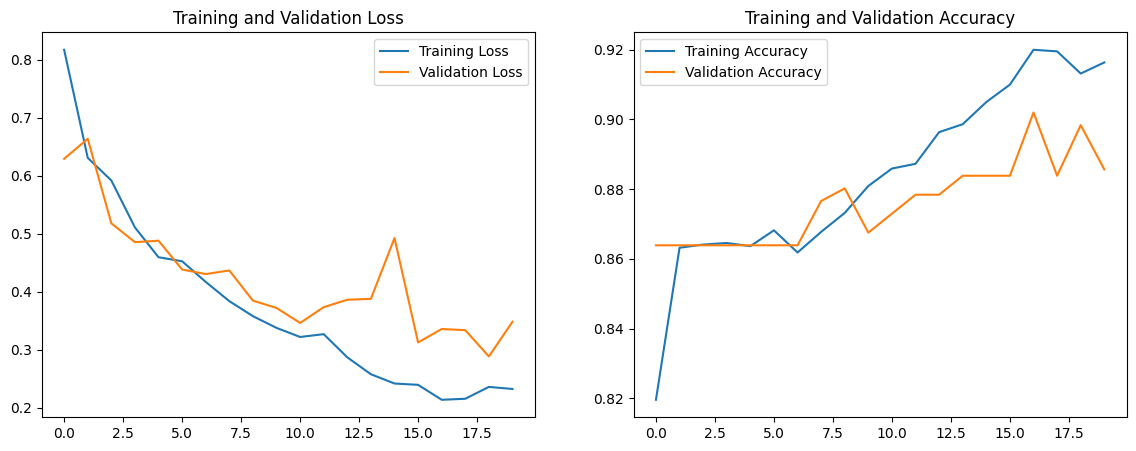

In [57]:
# Plotting loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(Conv1D_Model.history['loss'], label='Training Loss')
plt.plot(Conv1D_Model.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(Conv1D_Model.history['accuracy'], label='Training Accuracy')
plt.plot(Conv1D_Model.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


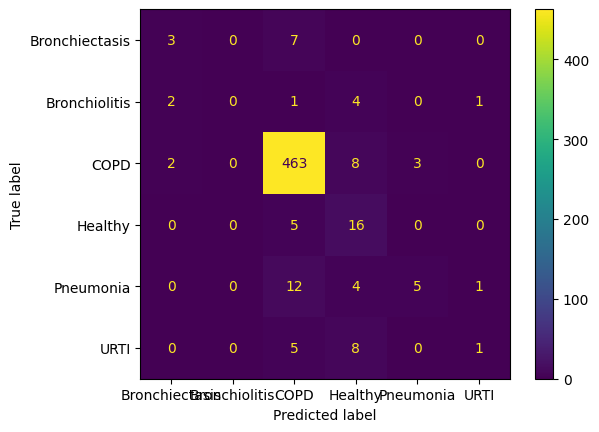

In [58]:
# Getting the predictions
y_pred = Model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generating the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Displaying the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()

In [107]:
# classification report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.43      0.30      0.35        10
           1       0.00      0.00      0.00         8
           2       0.94      0.97      0.96       476
           3       0.40      0.76      0.52        21
           4       0.62      0.23      0.33        22
           5       0.33      0.07      0.12        14

    accuracy                           0.89       551
   macro avg       0.45      0.39      0.38       551
weighted avg       0.87      0.89      0.87       551



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [113]:
# printing all the accuracy of the models

print("SVM model : ",accuracy_svm*100, "%")
print("Naive Bayes model : ",accuracy_nb*100 , "%")
print("KNN model : ",accuracy_knn*100 , "%")
print("Decision Tree model : ",accuracy_dtree*100 , "%")
print("1D CNN model : ",Model_Results[1]*100 , "%")


SVM model :  87.65880217785845 %
Naive Bayes model :  74.9546279491833 %
KNN model :  86.7513611615245 %
Decision Tree model :  85.84392014519057 %
1D CNN model :  88.56624364852905 %


conclusion: 1D CNN model performs better for the given dataset